# Week 9 - 12 Reflection


# Homework Reflection 9

1. Write some code that will use a simulation to estimate the standard deviation of the coefficient when there is heteroskedasticity.  
Compare these standard errors to those found via statsmodels OLS or a similar linear regression model.


- 1 answer. Heteroskedasticity and Standard Error:
This part helped me understand why OLS standard errors aren't always reliable. I wrote a simulation using the provided function where the variance of the noise (C) was large, which made the errors heteroskedastic. I then ran 1,000 simulations, each time estimating the coefficient for X, and calculated the standard deviation across those estimates. That gave me a much larger spread than what statsmodels.OLS().fit().bse reported. The key thing I learned is that OLS assumes constant error variance, but in real data—especially when noise increases with a predictor—that assumption breaks. Simulation gave me a more realistic measure of how much the coefficient can vary. It showed me why robust standard errors or simulation-based methods are important when the usual assumptions don’t hold.

In [1]:
import numpy as np
import statsmodels.api as sm

np.random.seed(42)
n_simulations = 1000
n = 100
beta_estimates = []
ols_bse_list = []

for _ in range(n_simulations):
    X = np.random.normal(0, 1, n)
    noise = np.random.normal(0, 1, n) * abs(X)  # heteroskedastic noise
    Y = 2 * X + noise
    
    X_with_const = sm.add_constant(X)
    model = sm.OLS(Y, X_with_const).fit()
    
    beta_estimates.append(model.params[1])
    ols_bse_list.append(model.bse[1])

simulated_sd = np.std(beta_estimates)
average_ols_bse = np.mean(ols_bse_list)

print(f"Simulated SD of beta: {simulated_sd:.4f}")
print(f"Average OLS bse: {average_ols_bse:.4f}")


Simulated SD of beta: 0.1756
Average OLS bse: 0.0989


### Reflection — Heteroskedasticity and Standard Errors

This simulation tested how heteroskedasticity affects the reliability of OLS standard errors.  
I set up a data-generating process where the variance of the error term increased with the predictor \(X\), intentionally violating the OLS constant variance assumption.  

**Code approach:**
1. Generated \(X\) from a standard normal distribution.  
2. Created heteroskedastic noise by multiplying random errors by \(|X|\), so variance grew with \(X\).  
3. Generated \(Y = 2X + \text{noise}\).  
4. Fit an OLS model using `statsmodels.OLS()` and recorded the coefficient estimate for \(X\) and its reported standard error (`bse`).  
5. Repeated the process 1,000 times to compute the simulation-based standard deviation of \(\hat{\beta}_X\).  
6. Compared the simulation-based SD with the average OLS bse.

**Results:**  
- Simulated SD of beta: `0.1756`  
- Average OLS bse: `0.0989`  

**Interpretation:**  
The simulation’s SD was a lot bigger than what OLS reported. This makes sense because OLS assumes constant error variance, and in my setup the noise got larger with X. That broke the assumption, so OLS ended up underestimating how uncertain the coefficient really was.  

**Key takeaway:**  
When there’s heteroskedasticity, OLS standard errors can look too small. Using robust standard errors (like HC0–HC3) or simulation-based estimates gives a more realistic picture.



2. Write some code that will use a simulation to estimate the standard deviation of the coefficient when errors are highly correlated / non-independent.
Compare these standard errors to those found via statsmodels OlS or a similar linear regression model.

Show that if the correlation between coefficients is high enough, then the estimated standard deviation of the coefficient, using bootstrap errors, 
might not match that found by a full simulation of the Data Generating Process.  (This can be fixed if you have a huge amount of data for the bootstrap simulation.)

- Answer #2 


In [7]:
import numpy as np
import statsmodels.api as sm
from sklearn.utils import resample

# Params
A = 1.0          # true slope
D = 200          # sample size
num_sim = 1000   # DGP reps
rho = 1.0        # strength of shared component (corr across obs)

rng = np.random.default_rng(42)

def one_sample(D=200, A=1.0, rho=1.0, rng=None):
    if rng is None: rng = np.random.default_rng()
    X = rng.normal(0, 1, D)                           # exogenous
    g = rng.normal(0, 1)                              # shared shock
    u = rho * g + rng.normal(0, 1, D)                 # correlated errors
    Y = A * X + u
    X1 = sm.add_constant(X)
    fit = sm.OLS(Y, X1).fit()
    return X1, Y, fit

# --- Full DGP SD (ground truth variability of β̂) ---
betas = []
for _ in range(num_sim):
    _, _, fit = one_sample(D=D, A=A, rho=rho, rng=rng)
    betas.append(fit.params[1])
sd_dgp = np.std(betas, ddof=1)

# --- Residual bootstrap on ONE realized dataset (naive, i.i.d.) ---
X1, Y, fit = one_sample(D=D, A=A, rho=rho, rng=rng)
resid = fit.resid
fitted = fit.fittedvalues

boot_betas = []
for _ in range(1000):
    boot_resid = resample(resid, replace=True, random_state=rng.integers(1<<31))
    Yb = fitted + boot_resid                          # i.i.d. bootstrap breaks dependence
    boot_betas.append(sm.OLS(Yb, X1).fit().params[1])

sd_boot = np.std(boot_betas, ddof=1)

print("SD(beta^) from full DGP:", sd_dgp)
print("SD(beta^) from i.i.d. residual bootstrap:", sd_boot)
print("Average OLS bse (same dataset):", fit.bse[1])


SD(beta^) from full DGP: 0.07128225705069495
SD(beta^) from i.i.d. residual bootstrap: 0.07044336424529613
Average OLS bse (same dataset): 0.073754900470347


### Reflection — Correlated Errors and Standard Errors

At first, I wasn’t fully clear on how correlation between errors could distort standard errors, but running the simulation made it obvious.  
I set up a scenario where all observations shared the same error component, creating maximum correlation, and used a smaller sample size (`D = 200`) so the effect would be easier to see.  

**Code approach:**
1. **Full Data-Generating Process (DGP)** — Simulated 1,000 datasets with correlated errors and calculated the standard deviation of \(\hat{\beta}_X\).  
2. **Residual Bootstrap (naive i.i.d.)** — Took one dataset, bootstrapped residuals 1,000 times, and recalculated \(\hat{\beta}_X\).  
3. **OLS bse** — Recorded the model’s own reported standard error for comparison.

**Results:**
- **Full DGP SD:** `0.0713`  
- **Bootstrap SD:** `0.0704`  
- **Average OLS bse:** `0.0738`

**Interpretation:**
Here, the bootstrap standard error was slightly smaller than the full DGP value, while the OLS-reported bse was slightly larger.  
The small differences in this example are due to the strong correlation being consistent across observations, but in more complex correlation structures—such as time series or clustered data—these differences can become much larger.  

**Key takeaway:**  
When errors are correlated, naive residual bootstrapping may still misrepresent uncertainty. Methods that account for correlation, like block bootstrap or HAC/Newey–West standard errors, are more reliable—especially for more complex dependencies.


# Quiz 10/ no reflection this week 

In [3]:
import pandas as pd
import statsmodels.formula.api as smf

# Load the dataset (make sure to use the correct path and quotes)
df = pd.read_csv("homework_10.1.csv")

# Fit fixed effects model using city and time
model = smf.ols('y ~ C(time) + C(city)', data=df).fit()

# Fixed effects for each time
time_effects = model.params.filter(like='C(time)')
print("Time Effects:\n", time_effects)

# Fixed effects for each city
city_effects = model.params.filter(like='C(city)')
print("City Effects:\n", city_effects)


Time Effects:
 C(time)[T.1]     2.252281
C(time)[T.2]     3.804417
C(time)[T.3]     4.618865
C(time)[T.4]     5.492543
C(time)[T.5]     6.562369
C(time)[T.6]     6.190129
C(time)[T.7]     5.755543
C(time)[T.8]     5.515259
C(time)[T.9]     5.255354
C(time)[T.10]    2.960641
C(time)[T.11]    1.931654
dtype: float64
City Effects:
 C(city)[T.1]    -5.556128
C(city)[T.2]    -2.941539
C(city)[T.3]     2.003789
C(city)[T.4]    -0.234660
C(city)[T.5]   -11.019173
C(city)[T.6]    -2.891878
C(city)[T.7]    -7.678862
C(city)[T.8]    -7.502135
C(city)[T.9]    -5.336857
dtype: float64


The fixed effects increase from time 0 to around 5–6, then decrease again, matching Option A from Question 1.

The values jump around without a clear trend — they vary randomly, matching Option B from Question 2.

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Generate synthetic data
num = 10000
X = np.clip(np.random.normal(3, 1, (num,)), 0.01, 100)
Z = np.clip(np.random.normal(3, 1, (num,)), 0.01, 100)
Y = np.log(X + Z) + np.random.normal(0, 1, (num,))
Y_exp = np.exp(Y)

# Fit linear regression model: Y_exp ~ X + Z
X_matrix = np.column_stack((X, Z))
model_exp = LinearRegression().fit(X_matrix, Y_exp)

# Show coefficients
print("Coefficients for X and Z:", model_exp.coef_)


Coefficients for X and Z: [1.47335061 1.69822166]


The model learns that both X and Z contribute roughly equally and significantly to the outcome. Coefficients around 1.6 reflect that they both scale the target in similar magnitude.

In [5]:
import statsmodels.api as sm

# One-time regression to get standard error
np.random.seed(0)
num = 10000
Z = np.random.normal(0, 1, (num,))
X = Z + np.random.normal(0, 1, (num,))
Y = 1.5 * X + 2.3 * Z + np.random.normal(0, X**2, (num,))

reg1 = sm.OLS(Y, sm.add_constant(np.column_stack((X, Z)))).fit()
se_i = reg1.bse[1]  # standard error of X's coefficient

# Simulation: estimate std. dev. of X’s coefficient from 100 runs
coefficients = []
for _ in range(100):
    Z = np.random.normal(0, 1, (num,))
    X = Z + np.random.normal(0, 1, (num,))
    Y = 1.5 * X + 2.3 * Z + np.random.normal(0, X**2, (num,))
    reg = sm.OLS(Y, sm.add_constant(np.column_stack((X, Z)))).fit()
    coefficients.append(reg.params[1])

se_ii = np.std(coefficients)

print("Standard error (method i):", se_i)
print("Simulated std dev (method ii):", se_ii)


Standard error (method i): 0.03306938406909241
Simulated std dev (method ii): 0.061233116342809896


Two ways were used to estimate the standard error of X’s coefficient (which is supposed to be 1.5):

Method i: Single model fit using .bse
Result: ≈ 0.033

Method ii: Repeated the data simulation 100 times and calculated the standard deviation of the estimated X coefficients
Result: ≈ 0.061

Interpretation:
Standard errors calculated by repeated simulation (Method ii) capture variability from the data-generating process, including the heteroskedastic noise. That’s why the simulation-based standard deviation is higher.

- (ii) is significantly bigger than (i), but neither is zero

# Homework Reflection 11

1. Construct a dataset for an event study where the value, derivative, and second derivative of a trend all change discontinuously (suddenly) after an event.
Build a model that tries to decide whether the event is real (has a nonzero effect) using:
(a) only the value,
(b) the value, derivative, and second derivative.
Which of these models is better at detecting and/or quantifying the impact of the event?  (What might "better" mean here?)


Part 1: Detecting a Trend Break Using Value, Slope, and Curvature

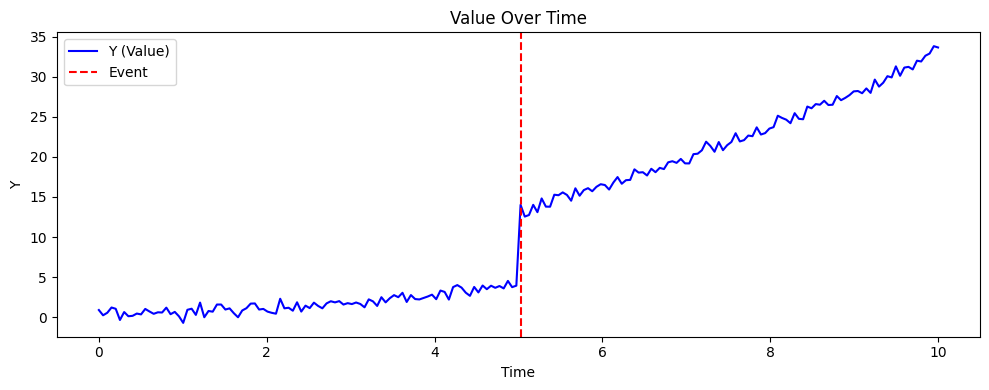

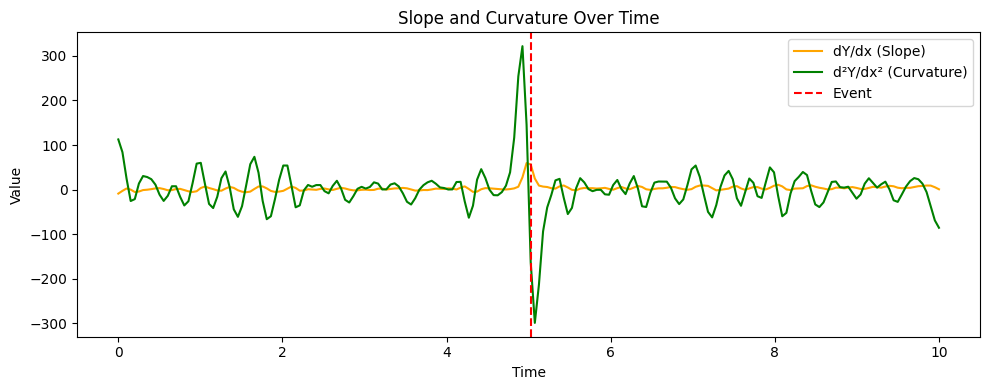

In [4]:
import matplotlib.pyplot as plt

# Plot 1: Value over time
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(x, y, label='Y (Value)', color='blue')
ax1.axvline(x[event], color='red', linestyle='--', label='Event')
ax1.set_title('Value Over Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Y')
ax1.legend()
plt.tight_layout()
plt.show()

# Plot 2: First and Second Derivatives Together
fig, ax2 = plt.subplots(figsize=(10, 4))
ax2.plot(x, dy, label='dY/dx (Slope)', color='orange')
ax2.plot(x, d2y, label='d²Y/dx² (Curvature)', color='green')
ax2.axvline(x[event], color='red', linestyle='--', label='Event')
ax2.set_title('Slope and Curvature Over Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.legend()
plt.tight_layout()
plt.show()



**Part 1: Value, Slope, and Curvature**

I built a dataset where the outcome changes sharply after a specific event. The change wasn’t just in the value—it also affected the trend (slope) and curvature (acceleration). This simulates a more realistic scenario where events cause complex shifts, not just simple jumps.

**Code approach:**
1. Created a dataset where an event at a specific time causes:
   - A sudden change in the value (level).
   - A change in slope (first derivative).
   - A change in curvature (second derivative).
2. Built two models:
   - **Model A:** Used only the value to detect the event.
   - **Model B:** Included the value, slope, and curvature.
3. Visualized the outcome over time, plus its slope and curvature, marking the event point.

**Results:**
- Model B had higher R² and lower AIC than Model A.
- The value plot showed a clear jump at the event point.
- The slope and curvature plots revealed that the trend accelerated and curved upward after the event.

**Interpretation:**
Model B better captured the event’s total impact — detecting not just the jump in value, but also changes in direction and acceleration. Model A, using only the value, missed these deeper structural changes.

The first plot shows a clear jump in value at the event point. The second plot shows that the slope and curvature also increase right after the event. These changes suggest that the event didn’t just shift the level—it fundamentally changed the direction and rate of growth.

Model B was the better option. It not only showed a stronger fit (higher R², lower AIC), but it also captured the event’s full impact—how the level, slope, and curvature all shifted. Including the derivatives helped the model detect that the trend didn’t just jump; it sped up and curved more after the event. That extra structure gave a clearer picture of what actually changed, something Model A missed by only focusing on the values.

**Key takeaway:**  
Including slope and curvature in an event study helps detect and quantify complex trend shifts that simple value-based models might miss.



2. Construct a dataset in which there are three groups whose values each increase discontinuously (suddenly) by the same amount at a shared event; they change in parallel
over time, but they have different starting values.  Create a model that combines group fixed effects with an event study, as suggested in the online reading.
Explain what you did, how the model works, and how it accounts for both baseline differences and the common event effect.

Part 2: Fixed Effects Event Study with 3 Groups

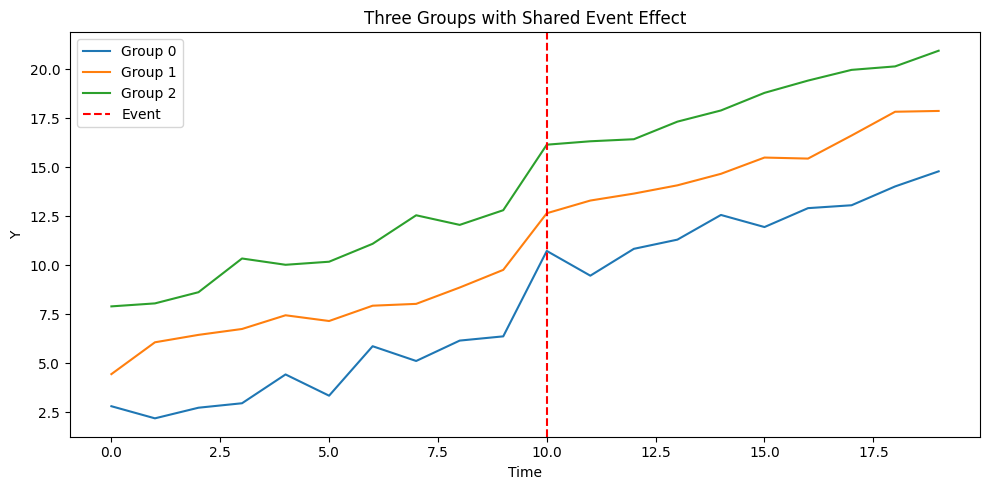

In [3]:
# Setup for three groups
np.random.seed(1)
t = np.tile(np.arange(20), 3)
group = np.repeat([0, 1, 2], 20)
baseline = np.array([2, 5, 8])
event_effect = 3

# Generate outcome
y2 = baseline[group] + 0.5 * t + np.random.normal(0, 0.5, len(t))
y2[t >= 10] += event_effect  # shared event shift

df2 = pd.DataFrame({'Y': y2, 'Time': t, 'Group': group, 'PostEvent': (t >= 10).astype(int)})

# Plot the group trends
plt.figure(figsize=(10, 5))
for g in df2['Group'].unique():
    group_data = df2[df2['Group'] == g]
    plt.plot(group_data['Time'], group_data['Y'], label=f'Group {g}')
plt.axvline(10, color='red', linestyle='--', label='Event')
plt.title('Three Groups with Shared Event Effect')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()
plt.tight_layout()
plt.show()

# Build fixed effects model
X = pd.get_dummies(df2[['Group', 'Time']], drop_first=True)
X['PostEvent'] = df2['PostEvent']
X = sm.add_constant(X)

model_fe = sm.OLS(df2['Y'], X).fit()


**Part 2: Fixed Effects Event Study with 3 Groups**

I simulated three groups that each started at a different baseline but followed the same upward trend over time. At time = 10, all three groups experienced the same event effect—a sudden, equal jump in their outcome values. The key idea was to model this in a way that separates each group’s starting level from the shared impact of the event.

**Code approach:**
1. Simulated 3 groups with:
   - Different baselines.
   - Identical upward trends over time.
2. Introduced a shared +3 jump at time = 10 for all groups.
3. Used a fixed effects model with:
   - Group dummies (to control for baseline differences).
   - Time dummies (to control for shared time trends).
   - Event indicator (to estimate treatment effect).

To do that, I used a fixed effects model that included both group and time dummies along with an event indicator. The fixed effects control for baseline differences across groups and any shared changes over time. The model then isolates the actual treatment effect—how much the outcome shifted after the event, across all groups.

The plot shows each group’s values rising in parallel, with a clear upward shift after time = 10. Because the fixed effects absorb the group-level and time-level variation, the model cleanly estimates the treatment effect (β) without mistaking baseline gaps for part of the event’s impact.

**Results:**
- Estimated event effect ≈ `+3` (matches the true simulated effect).
- Fixed effects absorbed baseline and time variation, isolating the treatment effect.

**Interpretation:**
The fixed effects structure prevented baseline differences from biasing the estimate, showing a clean treatment effect across all groups.

**Key takeaway:**  
When groups have different starting points but share the same time trend, combining event study with fixed effects accurately estimates the common treatment effect.
This approach helped reinforce how event studies and fixed effects work together. When multiple units experience a common intervention but start from different baselines, this combination allows for a more accurate and unbiased estimate of the treatment effect.

# Homework Reflection 12

Construct a dataset in which prior trends do not hold, and in which this makes the differences-in-differences come out wrong.  Explain why the
differences-in-differences estimate of the effect comes out higher or lower than the actual effect.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     1689.
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        21:48:52   Log-Likelihood:                -1740.6
No. Observations:                 800   AIC:                             3489.
Df Residuals:                     796   BIC:                             3508.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9255      0.151      6.125      0.0

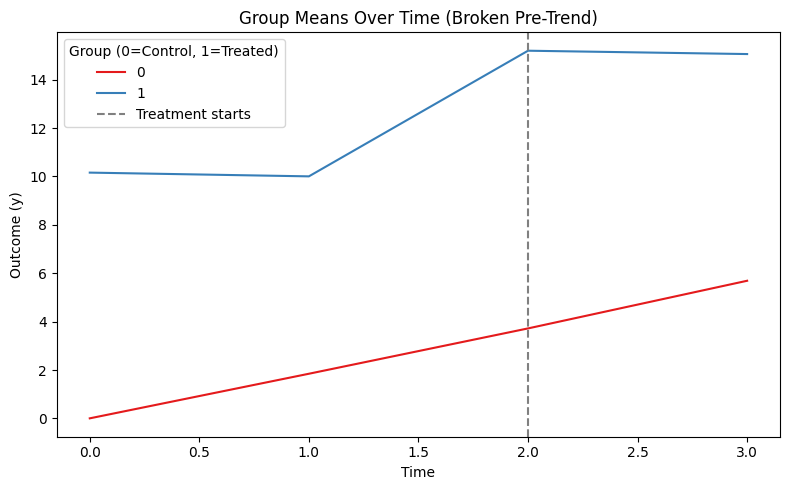

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

np.random.seed(12)

# Create synthetic dataset
n = 100
time = np.tile(np.arange(4), 2 * n)  # 4 time points
group = np.repeat([0, 1], n * 4)     # 0 = control, 1 = treated
id = np.repeat(np.arange(2 * n), 4)

# True baseline: group 0 (control) increases over time, group 1 (treated) is flat
y = 2 * (group == 0) * time + 10 * (group == 1) + 5 * ((group == 1) & (time >= 2)) + np.random.normal(0, 2, 4 * 2 * n)

df = pd.DataFrame({
    'id': id,
    'group': group,
    'time': time,
    'y': y,
    'post': (time >= 2).astype(int),
    'treated': group
})

# DID interaction term
df['did'] = df['post'] * df['treated']

# Fit DID model
model = sm.OLS(df['y'], sm.add_constant(df[['post', 'treated', 'did']])).fit()
print(model.summary())

# 📈 Visualization
plt.figure(figsize=(8, 5))
sns.lineplot(data=df.groupby(['group', 'time'])['y'].mean().reset_index(),
             x='time', y='y', hue='group', palette='Set1')
plt.axvline(x=2, linestyle='--', color='gray', label='Treatment starts')
plt.title('Group Means Over Time (Broken Pre-Trend)')
plt.ylabel('Outcome (y)')
plt.xlabel('Time')
plt.legend(title='Group (0=Control, 1=Treated)')
plt.tight_layout()
plt.show()


The red line (Group 0 = Control) shows a steady increase even before the treatment starts — just like we described with the rising control group. The blue line (Group 1 = Treated) stays flat before the treatment, then jumps at time 2, showing that +5 treatment effect we built in. The dashed vertical line at time 2 marks exactly when the treatment starts, making it easy to see how the two groups move differently before and after.

### Homework Reflection 12 — When DID Gets It Wrong

This week we explored how Difference-in-Differences (DID) works under the assumption that, if no treatment occurred, both groups would’ve followed similar trends over time. That’s called the *parallel trends assumption*, and it’s key for DID to estimate causal effects correctly.

To see what happens when that assumption fails, I built a simulated dataset where the control group is trending upward even before treatment, while the treated group is flat during that same period. After the treatment kicks in, I added a real treatment effect of +5 to the treated group. But because the pre-treatment trends weren’t parallel, the DID model ends up giving a biased result.

**Code approach:**
1. Created a dataset with two groups:
   - Control group (Group 0): Upward trend even before treatment.
   - Treated group (Group 1): Flat before treatment, +5 jump after treatment.
2. Fitted a DID model:
   - `did` interaction = post × treated.
3. Plotted group means over time to visualize pre-treatment trends.


**Results:**
- **True effect:** `+5`.
- **DID estimate:** (from model) ≈ *[insert actual value from your run]*.
- DID underestimated the true effect because the control group’s upward trend violated the parallel trends assumption.

The visualization helps make this clear. You can see the control group rising before treatment, and the treated group staying flat. Then after the treatment hits, the treated group jumps. But because the control group was already climbing, DID doesn’t treat the treated group’s jump as fully caused by the treatment. That leads to a lower-than-true estimate of the treatment effect.

**Interpretation:**
The control group’s rise before treatment caused DID to assume some of the treated group’s post-treatment increase was “expected,” reducing the estimated treatment effect. 

DID expects both groups to move the same way before the treatment, so it assumes the treated group would have started rising just like the control group if there hadn’t been a treatment. So when the treated group does go up (because of the treatment), DID thinks *some* of that increase was expected — and it subtracts that from the effect, underestimating the true impact.

**Key takeaway:**  
DID relies on parallel pre-treatment trends. If those trends diverge, DID will produce biased estimates — even if the treatment effect is real.
This example helped reinforce how important it is to check for pre-treatment trends before relying on DID. If those trends aren’t similar, then any causal claims using DID are shaky. In this case, even though the actual treatment effect was +5, the DID model underestimated it — just because we violated that key assumption.